In [18]:
import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import copy

import sys
sys.path.append("../")
import data_helpers

In [19]:
tires = ["r25b_16x7-5_10x8","r25b_16x7-5_10x7","r25b_16x7-5_10x7","r25b_18x6_10x6","r25b_16x6_10x7","r25b_18x7-5_10x8","r25b_18x7-5_10x7",
        "LCO_16x7-5_10x8","LCO_16x7-5_10x7","LCO_16x7-5_10x7","LCO_18x6_10x6","LCO_16x6_10x7","LCO_18x7-5_10x8","LCO_18x7-5_10x7"]

tire_coeffs = {tire:{"lateral_mus":[], "long_mus":[]} for tire in tires}

camber = 0 # default camber
pressure = 12* 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
SA_cutoff = 8 # degrees, where slip occurs
SR_cutoff = 0.1 # %, where slip occurs

load_lateral = np.array([-250, -200, -150, -50]) / 0.224809
load_long = np.array([-250, -200, -150, -50]) / 0.224809

In [20]:
df = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/braking_hoosier_r25b_18x7-5_10x7.mat"))

In [21]:
variable_sweeps = {"load" : {"sweep" : np.array([-250, -200, -150, -50]) / 0.224809, "label" : "FZ" },
            "camber" : {"sweep" : np.array([0, 2, 4]), "label" : "IA"},
            "pressure" : {"sweep" : np.array([8, 10, 12, 14]) * 6.89476, "label" : "P"},
            "velocity" : {"sweep" : np.array([25]) * 1.60934, "label" : "V"},
            "slip" : {"sweep" : np.array([0, -3, -6]), "label" : "SA"}}

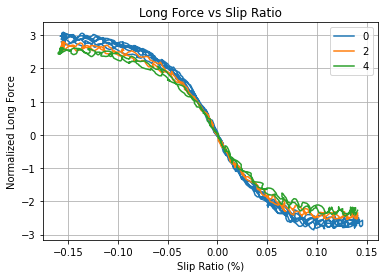

In [22]:
initial_tire = 35 # run ID number
post_tire = 36 # run ID number
slip_angle = 0 # pure long loading
pressure = 12*6.89476 # default pressure
camber = 0 # default camber


for c in [0, 2, 4]:
    initial_df = df[((df["slip"] == slip_angle) & (df["pressure"] == pressure) & (df["camber"] == c) & (df["RUN"] == initial_tire))]
    post_df = df[((df["slip"] == slip_angle) & (df["pressure"] == pressure) & (df["camber"] == c) & (df["RUN"] == post_tire))]

    #ax2.plot(post_df["SL"], post_df["NFX"], 'y')
    initial_max_data, post_max_data = pd.DataFrame(), pd.DataFrame()

    # go through each normal load in discrete sweep
    for x in [variable_sweeps["load"]["sweep"][0]]:
        load_df = initial_df[initial_df["load"] == x]
        load_df_2 = post_df[post_df["load"] == x]
        plt.plot(load_df["SL"], load_df["NFX"], label = c)
        #ax2.plot(load_df_2["SL"], load_df_2["NFX"], label = x)


        max_mu = initial_df[initial_df["load"] == x]["NFX"].max()
        max_data = initial_df[initial_df["NFX"] == max_mu]
        initial_max_data = pd.concat((initial_max_data, max_data))
        #ax1.plot(max_data["SL"], max_data["NFX"], 'x', label = x)
        #print("Force: ", x, max_data["NFX"]*2/3,max_data["SL"],"\n")

        max_mu = post_df[post_df["load"] == x]["NFX"].max()
        max_data = post_df[post_df["NFX"] == max_mu]
        post_max_data = pd.concat((post_max_data, max_data))
        #ax2.plot(max_data["SL"], max_data["NFX"], 'x', label = x)
        #print("Force: ", x, max_data["NFX"]*2/3,max_data["SL"],"\n")


            # # TESTING
            # max_mu = initial_df[initial_df["load"] == x]["FX"].max()
            # max_data = initial_df[initial_df["FX"] == max_mu]
            # ax1.plot(max_data["SL"], max_data["NFX"], 'x')
    plt.legend()
    plt.ylabel("Normalized Long Force")
    plt.xlabel("Slip Ratio (%)")
    plt.title("Long Force vs Slip Ratio")
    plt.grid()
    #ax2.legend()


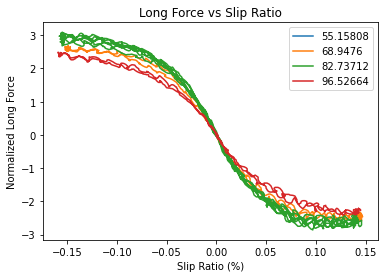

In [23]:
initial_tire = 35 # run ID number
post_tire = 36 # run ID number
slip_angle = 0 # pure long loading
pressure = 12*6.89476 # default pressure
camber = 0 # default camber


for p in np.array([8, 10, 12, 14]) * 6.89476:
    initial_df = df[((df["slip"] == slip_angle) & (df["pressure"] == p) & (df["camber"] == camber) & (df["RUN"] == initial_tire))]
    post_df = df[((df["slip"] == slip_angle) & (df["pressure"] == p) & (df["camber"] == camber) & (df["RUN"] == post_tire))]

    #ax2.plot(post_df["SL"], post_df["NFX"], 'y')
    initial_max_data, post_max_data = pd.DataFrame(), pd.DataFrame()

    # go through each normal load in discrete sweep
    for x in [variable_sweeps["load"]["sweep"][0]]:
        load_df = initial_df[initial_df["load"] == x]
        load_df_2 = post_df[post_df["load"] == x]
        plt.plot(load_df["SL"], load_df["NFX"], label = p)
        #ax2.plot(load_df_2["SL"], load_df_2["NFX"], label = x)


        max_mu = initial_df[initial_df["load"] == x]["NFX"].max()
        max_data = initial_df[initial_df["NFX"] == max_mu]
        initial_max_data = pd.concat((initial_max_data, max_data))
        #ax1.plot(max_data["SL"], max_data["NFX"], 'x', label = x)
        #print("Force: ", x, max_data["NFX"]*2/3,max_data["SL"],"\n")

        max_mu = post_df[post_df["load"] == x]["NFX"].max()
        max_data = post_df[post_df["NFX"] == max_mu]
        post_max_data = pd.concat((post_max_data, max_data))
        #ax2.plot(max_data["SL"], max_data["NFX"], 'x', label = x)
        #print("Force: ", x, max_data["NFX"]*2/3,max_data["SL"],"\n")


            # # TESTING
            # max_mu = initial_df[initial_df["load"] == x]["FX"].max()
            # max_data = initial_df[initial_df["FX"] == max_mu]
            # ax1.plot(max_data["SL"], max_data["NFX"], 'x')
    plt.legend()
    plt.ylabel("Normalized Long Force")
    plt.xlabel("Slip Ratio (%)")
    plt.title("Long Force vs Slip Ratio")
    plt.grid()
    #ax2.legend()

Average reduction after usage nan%
Pre Quadratic term: 0.0007219237522736346
Pre Linear term: 2.012445859872612


LinAlgError: SVD did not converge in Linear Least Squares

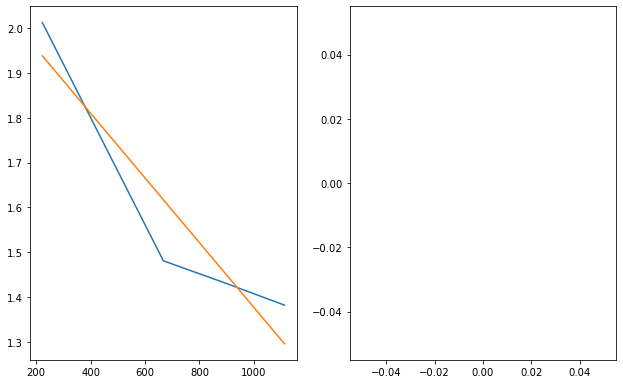

In [24]:
def get_normal_mus(df, normal_loads, lower, metric = "SL", output = "NFX"):
    return_mus = []
    for x in normal_loads:
        load_df = df[(df["load"] == x) & ((df[metric] < -1*lower) | (df[metric] > lower))]
        return_mus.append(load_df[output].abs().mean()*0.6)
    return return_mus

loads = variable_sweeps["load"]["sweep"]
initial_mus = get_normal_mus(initial_df, loads, 0.10)
post_mus = get_normal_mus(post_df, loads, 0.10)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10.5, 6.5)

reduc = [1 - post_mus[i]/initial_mus[i] for i in range(len(loads))]
print("Average reduction after usage {0}%".format(sum(reduc)/len(reduc)))
ax1.plot(-1*loads, initial_mus)
ax2.plot(-1*loads, post_mus)
func = np.polyfit(loads, initial_mus, 1)

ax1.plot(-1*loads, func[1] + func[0] * loads)
print("Pre Quadratic term:", func[0])
print("Pre Linear term:", initial_mus[len(initial_mus)-1])


func = np.polyfit(loads, post_mus, 1)
ax2.plot(-1*loads, func[1] + func[0] * loads)
print("Post Quadratic term:", func[0])
print("Post Linear term:", post_mus[len(post_mus)-1])

# # go through each normal load in discrete sweep
# for x in variable_sweeps["load"]["sweep"]:
#     load_df = initial_df[initial_df["load"] == x]
ax1.grid()
ax2.grid()
ax1.set_title("r25b_18x7.5_10x7 Pre Wear MU vs Normal Force")
ax2.set_title("Post Wear MU vs Normal Force")
ax1.set_ylabel("Long MU")
ax2.set_ylabel("Long MU")
ax1.set_xlabel("Normal Force (N)")
ax2.set_xlabel("Normal Force (N)")

In [ ]:
df2 = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/braking_hoosier_r25b_18x6_10x7.mat"))

initial_tire = 43 # run ID number
slip_angle = 0 # pure long loading
pressure = 12*6.89476 # default pressure
camber = 0 # default camber

initial_df = df2[((df2["slip"] == slip_angle) & (df2["pressure"] == pressure) & (df2["camber"] == camber) & (df2["RUN"] == initial_tire))]

loads = variable_sweeps["load"]["sweep"]
initial_mus = get_normal_mus(initial_df, loads, 0.10)

plt.plot(loads, initial_mus)
func = np.polyfit(loads, initial_mus, 1)
print(func)

plt.plot(loads, func[1] + func[0] * loads)
print("Quadratic term:", func[0])
print("Linear term:", initial_mus[len(initial_mus)-1])

In [ ]:
df2 = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/braking_hoosier_r25b_18x6_10x6.mat"))

initial_tire = 41 # run ID number
slip_angle = 0 # pure long loading
pressure = 12*6.89476 # default pressure
camber = 0 # default camber

initial_df = df2[((df2["slip"] == slip_angle) & (df2["pressure"] == pressure) & (df2["camber"] == camber) & (df2["RUN"] == initial_tire))]

loads = variable_sweeps["load"]["sweep"]
initial_mus = get_normal_mus(initial_df, loads, 0.10)

plt.plot(loads, initial_mus)
func = np.polyfit(loads, initial_mus, 1)
print(func)

plt.plot(loads, func[1] + func[0] * loads)
print("Quadratic term:", func[0])
print("Linear term:", initial_mus[len(initial_mus)-1])

In [ ]:
# go through each normal load in discrete sweep
for x in variable_sweeps["load"]["sweep"]:
    load_df = initial_df[initial_df["load"] == x]
    load_df_2 = post_df[post_df["load"] == x]
    plt.plot(load_df["SL"], load_df["NFX"], label = x)

In [ ]:
df3 = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/cornering_2021_rears.mat"))

loads_lat = np.array([-250, -200, -150, -100, -50]) / 0.224809

initial_tire = 21 # run ID number
post_tire = 22  # run ID number
pressure = 12*6.89476 # default pressure
camber = 0 # default camber
velocity = 25* 1.60934 # default velocity
slip_angle = 8

initial_df = df3[((df3["velocity"] == velocity) & (df3["pressure"] == pressure) & (df3["camber"] == camber) & (df3["RUN"] == initial_tire))]
post_df = df3[((df3["velocity"] == velocity) & (df3["pressure"] == pressure) & (df3["camber"] == camber) & (df3["RUN"] == post_tire))]

# go through each normal load in discrete sweep
# for x in loads_lat:
#     load_df = initial_df[initial_df["load"] == x]
#     plt.plot(load_df["SA"], load_df["NFY"], label = x)

initial_mus = get_normal_mus(initial_df, loads_lat, slip_angle, "SA", "NFY")
post_mus = get_normal_mus(post_df, loads_lat, slip_angle, "SA", "NFY")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10.5, 6.5)

reduc = [1 - post_mus[i]/initial_mus[i] for i in range(len(loads_lat))]
print("Average reduction after usage {0}%".format(sum(reduc)/len(reduc)))
ax1.plot(-1*loads_lat, initial_mus)
ax2.plot(-1*loads_lat, post_mus)
func = np.polyfit(loads_lat, initial_mus, 1)

ax1.plot(-1*loads_lat, func[1] + func[0] * loads_lat)
print("Pre Quadratic term:", func[0])
print("Pre Linear term:", initial_mus[len(initial_mus)-1])


func = np.polyfit(loads_lat, post_mus, 1)
ax2.plot(-1*loads_lat, func[1] + func[0] * loads_lat)
print("Post Quadratic term:", func[0])
print("Post Linear term:", post_mus[len(post_mus)-1])

ax1.grid()
ax2.grid()
ax1.set_title("r25b_18x7.5_10x7 Pre Wear MU vs Normal Force")
ax2.set_title("Post Wear MU vs Normal Force")
ax1.set_ylabel("Lat MU")
ax2.set_ylabel("Lat MU")
ax1.set_xlabel("Normal Force (N)")
ax2.set_xlabel("Normal Force (N)")

In [ ]:
df4 = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/cornering_2021_fronts_10x7.mat"))

loads_lat = np.array([-250, -200, -150, -100, -50]) / 0.224809

initial_tire = 12 # run ID number
post_tire = 13  # run ID number
pressure = 12*6.89476 # default pressure
camber = 0 # default camber
velocity = 25* 1.60934 # default velocity
slip_angle = 8

initial_df = df4[((df4["velocity"] == velocity) & (df4["pressure"] == pressure) & (df4["camber"] == camber) & (df4["RUN"] == initial_tire))]
post_df = df4[((df4["velocity"] == velocity) & (df4["pressure"] == pressure) & (df4["camber"] == camber) & (df4["RUN"] == post_tire))]

# go through each normal load in discrete sweep
# for x in loads_lat:
#     load_df = initial_df[initial_df["load"] == x]
#     plt.plot(load_df["SA"], load_df["NFY"], label = x)

initial_mus = get_normal_mus(initial_df, loads_lat, slip_angle, "SA", "NFY")
post_mus = get_normal_mus(post_df, loads_lat, slip_angle, "SA", "NFY")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

reduc = [1 - post_mus[i]/initial_mus[i] for i in range(len(loads_lat))]
print("Average reduction after usage {0}%".format(sum(reduc)/len(reduc)))
ax1.plot(loads_lat, initial_mus)
ax2.plot(loads_lat, post_mus)
func = np.polyfit(loads_lat, initial_mus, 1)

ax1.plot(loads_lat, func[1] + func[0] * loads_lat)
print("Pre Quadratic term:", func[0])
print("Pre Linear term:", initial_mus[len(initial_mus)-1])


func = np.polyfit(loads_lat, post_mus, 1)
ax2.plot(loads_lat, func[1] + func[0] * loads_lat)
print("Post Quadratic term:", func[0])
print("Post Linear term:", post_mus[len(post_mus)-1])

In [ ]:
df5 = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/cornering_2021_r25b_16x7-5_10x8.mat"))

loads_lat = np.array([-250, -200, -150, -100, -50]) / 0.224809

initial_tire = 6 # run ID number
post_tire = 7  # run ID number
pressure = 12*6.89476 # default pressure
camber = 0 # default camber
velocity = 25* 1.60934 # default velocity
slip_angle = 8

initial_df = df5[((df5["velocity"] == velocity) & (df5["pressure"] == pressure) & (df5["camber"] == camber) & (df5["RUN"] == initial_tire))]
post_df = df5[((df5["velocity"] == velocity) & (df5["pressure"] == pressure) & (df5["camber"] == camber) & (df5["RUN"] == post_tire))]

# go through each normal load in discrete sweep
# for x in loads_lat:
#     load_df = initial_df[initial_df["load"] == x]
#     plt.plot(load_df["SA"], load_df["NFY"], label = x)

initial_mus = get_normal_mus(initial_df, loads_lat, slip_angle, "SA", "NFY")
post_mus = get_normal_mus(post_df, loads_lat, slip_angle, "SA", "NFY")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

reduc = [1 - post_mus[i]/initial_mus[i] for i in range(len(loads_lat))]
print("Average reduction after usage {0}%".format(sum(reduc)/len(reduc)))
ax1.plot(loads_lat, initial_mus)
ax2.plot(loads_lat, post_mus)
func = np.polyfit(loads_lat, initial_mus, 1)

ax1.plot(loads_lat, func[1] + func[0] * loads_lat)
print("Pre Quadratic term:", func[0])
print("Pre Linear term:", initial_mus[len(initial_mus)-1])


func = np.polyfit(loads_lat, post_mus, 1)
ax2.plot(loads_lat, func[1] + func[0] * loads_lat)
print("Post Quadratic term:", func[0])
print("Post Linear term:", post_mus[len(post_mus)-1])

In [ ]:
df = data_helpers.import_data(sio.loadmat("../tire_data/processed_data/camber_hoosier_r25b_16x7-5_10x8.mat"))
#df = df[((df["velocity"] == velocity) & (df["pressure"] == pressure))]
plt.scatter(df["IA"], df["NFY"])
# velocity, pressure, slip_angle